In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
from PIL import Image

import sys
sys.path.append("/nfs/stak/users/vuonga2/codes/ddpm_torch")
from ddpm_simple import DDPM
from unet_simple_2 import Unet

In [2]:
device="cuda:0"

ddpm = DDPM(
    nn_model=Unet(in_channels=1, n_features=256, embed_method="cosine"),
    beta1=1e-4,
    beta2=0.02,
    T=400,
    device=device,
    drop_prob=0.1,
)

total_params = sum([p.numel() for p in ddpm.parameters()])
print("Model initialized, total params = ", total_params)

ddpm.load_state_dict(torch.load("../data/diffusion_outputs10_2/model_30.pth", map_location=device))

Model initialized, total params =  25644289


<All keys matched successfully>

In [23]:
def show_image(x):
    grid = make_grid(xi, nrow=4)
    # grid = grid.permute(1, 2, 0)
    # x = 1-grid.detach().cpu().numpy()
    # x = (x-x.min())/(x.max()-x.min())
    x = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
    im = Image.fromarray(x)
    return im

def noise_schedule(beta1, beta2, T):
    assert beta1 < beta2 < 1.0
    # linear schedule
    beta_t = torch.linspace(beta1, beta2, T + 1)

    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,
        "oneover_sqrta": oneover_sqrta,
        "sqrt_beta_t": sqrt_beta_t,
        "alphabar_t": alphabar_t,
        "sqrtab": sqrtab,
        "sqrtmab": sqrtmab,
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,
    }

In [47]:
n_sample = 8
size = (1,28,28)

# generate randomness first for easy debug
x_init = torch.randn(n_sample, 1, 28, 28).to(device)
z_list = []
for i in range(1000):
    z = torch.randn(n_sample, *size).to(device)
    z_list.append(z)

In [61]:
linear_T = np.arange(new_T, 0, -skip)
random_T = np.sort(np.random.choice(np.arange(ddpm.T), new_T))[::-1]

In [89]:
new_T = 200
skip = ddpm.T//new_T
use_new_schedule = False

linear_T = np.arange(new_T, 0, -skip)
random_T = np.sort(np.random.choice(np.arange(ddpm.T), new_T))[::-1]

Ts = random_T

ddpm.eval()
xi = x_init
if use_new_schedule:
    # recalculate noise schedule 
    schedule = noise_schedule(beta1=1e-4, beta2=0.02, T=new_T)
    with torch.no_grad():
        # xi = torch.randn(n_sample, 1, 28, 28).to(device)
    
        for i in tqdm.tqdm(Ts):
            ti = torch.tensor([i / ddpm.T]).type(torch.FloatTensor).to(device)
            ti = ti.repeat(n_sample, 1, 1, 1)
    
            noise_pred = ddpm.nn_model(xi, ti)
            # z = torch.randn(n_sample, *size).to(device)
            z = z_list[i]
            if i <= 1:
                z = 0
    
            # ancestral sampling
            xi = (
                schedule["oneover_sqrta"][i] * (xi - noise_pred * schedule["mab_over_sqrtmab"][i])
                + schedule["sqrt_beta_t"][i] * z
            )
else:
    with torch.no_grad():
        # xi = torch.randn(n_sample, 1, 28, 28).to(device)
    
        for i in tqdm.tqdm(Ts):
            ti = torch.tensor([i / ddpm.T]).type(torch.FloatTensor).to(device)
            ti = ti.repeat(n_sample, 1, 1, 1)
    
            noise_pred = ddpm.nn_model(xi, ti)
            # z = torch.randn(n_sample, *size).to(device)
            z = z_list[i]
            if i <= 1:
                z = 0
    
            # ancestral sampling
            xi = (
                ddpm.oneover_sqrta[i] * (xi - noise_pred * ddpm.mab_over_sqrtmab[i])
                + ddpm.sqrt_beta_t[i] * z
            )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.93it/s]


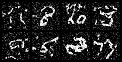

In [90]:
im = show_image(xi)
im

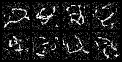

In [76]:
im = show_image(xi)
im

In [18]:
for i in tqdm.tqdm(range(n_sample)):
    im = xi[i]
    save_image(im, f"generated_images/T{new_T}/im_{i}.jpg")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 223.20it/s]
